In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# load data

folder_path = "yourfolderpath"

# air
air_reserve_df = pd.read_csv(folder_path + "/air_reserve.csv")
air_store_info_df = pd.read_csv(folder_path + "/air_store_info.csv")
air_visit_data_df = pd.read_csv(folder_path + "/air_visit_data.csv")

# hpg
hpg_reserve_df = pd.read_csv(folder_path + "/hpg_reserve.csv")
hpg_store_info_df = pd.read_csv(folder_path + "/hpg_store_info.csv")

# date info
date_info_df = pd.read_csv(folder_path + "/date_info.csv")

# relation
store_id_relation_df = pd.read_csv(folder_path + "/store_id_relation.csv")

In [ ]:
print(air_reserve_df['air_store_id'].nunique())
print(hpg_reserve_df['hpg_store_id'].nunique())
print(store_id_relation_df.shape[0])

314
13325
150


In [ ]:
# check null values in data

def check_null_values(df: pd.DataFrame):
    return np.any(df.isna().sum() > 1)

print("Null values check".center(50, "="))
print()
print("air_visit_data_df :", check_null_values(air_visit_data_df))
print("air_reserve_df :", check_null_values(air_reserve_df))
print("air_store_info_df :", check_null_values(air_store_info_df))
print("date_info_df :", check_null_values(date_info_df))
print("hpg_reserve_df :", check_null_values(hpg_reserve_df))
print("hpg_store_info_df :", check_null_values(hpg_store_info_df))
print("store_id_relation_df :", check_null_values(store_id_relation_df))

================Null values check=================

air_visit_data_df : False
air_reserve_df : False
air_store_info_df : False
date_info_df : False
hpg_reserve_df : False
hpg_store_info_df : False
store_id_relation_df : False


In [ ]:
# merge air_visit_data_df and date_info_df to train_df

# type conversion
air_visit_data_df.visit_date = pd.to_datetime(air_visit_data_df.visit_date)
date_info_df.calendar_date = pd.to_datetime(date_info_df.calendar_date)

date_info_df.rename(columns={'calendar_date': 'visit_date'}, inplace=True)
train_df = pd.merge(air_visit_data_df, date_info_df, how='left', on="visit_date")

# sort by visit_date
train_df.sort_values(by='visit_date', inplace=True, ignore_index=True)

# print("train_df :", check_null_values(train_df))
# print(air_visit_data_df.head())
# print(date_info_df.head())
# print(train_df.head())

In [ ]:
# merge train_df and air_store_info_df to train_df

train_df = pd.merge(train_df, air_store_info_df, how='left', on='air_store_id')

# print("train_df :", check_null_values(train_df))
print(train_df.head())

           air_store_id visit_date  visitors day_of_week  holiday_flg  \
0  air_fab092c35776a9b1 2016-01-01        19      Friday            1   
1  air_f26f36ec4dc5adb0 2016-01-01        64      Friday            1   
2  air_d97dabf7aae60da5 2016-01-01       102      Friday            1   
3  air_39dccf7df20b1c6a 2016-01-01        55      Friday            1   
4  air_79f528087f49df06 2016-01-01        42      Friday            1   

  air_genre_name                       air_area_name   latitude   longitude  
0    Cafe/Sweets     Fukuoka-ken Fukuoka-shi Momochi  33.581941  130.348436  
1        Izakaya      Tōkyō-to Shinjuku-ku Kabukichō  35.693840  139.703549  
2    Cafe/Sweets        Tōkyō-to Shibuya-ku Jingūmae  35.669290  139.707056  
3        Izakaya    Hyōgo-ken Takarazuka-shi Tōyōchō  34.799767  135.360073  
4   Western food  Tōkyō-to Suginami-ku Asagayaminami  35.699566  139.636438  


In [ ]:
# merge train_df and air_reserve_df to train_df

# type conversion
air_reserve_df.visit_datetime = pd.to_datetime(air_reserve_df.visit_datetime)
air_reserve_df.reserve_datetime = pd.to_datetime(air_reserve_df.reserve_datetime)

# add vr_gap_time --> ( visit time - reserve time )
# unit: 1 hour
air_reserve_diff = air_reserve_df.visit_datetime - air_reserve_df.reserve_datetime
air_reserve_diff = air_reserve_diff / np.timedelta64(1, 'h')
air_reserve_df["vr_gap_time"] = air_reserve_diff

# add visit_date
air_reserve_df['visit_date'] = air_reserve_df.visit_datetime.dt.date

print(air_reserve_df.head())

# reservations and visits on the same day
rv_same_day_count_df = air_reserve_df.groupby(by=['air_store_id', 'visit_date'], as_index=False)[['reserve_visitors', 'vr_gap_time']].sum()
rv_same_day_count_df.visit_date = pd.to_datetime(rv_same_day_count_df.visit_date)

print(rv_same_day_count_df.head())

# merge to train_df
train_df = pd.merge(train_df, rv_same_day_count_df, how='left', on=['visit_date', 'air_store_id'])
train_df.fillna(0, inplace=True)
# print(train_df.head())

           air_store_id      visit_datetime    reserve_datetime  \
0  air_877f79706adbfb06 2016-01-01 19:00:00 2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
3  air_877f79706adbfb06 2016-01-01 20:00:00 2016-01-01 16:00:00   
4  air_db80363d35f10926 2016-01-01 20:00:00 2016-01-01 01:00:00   

   reserve_visitors  vr_gap_time  visit_date  
0                 1          3.0  2016-01-01  
1                 3          0.0  2016-01-01  
2                 6          0.0  2016-01-01  
3                 2          4.0  2016-01-01  
4                 5         19.0  2016-01-01  
           air_store_id visit_date  reserve_visitors  vr_gap_time
0  air_00a91d42b08b08d9 2016-10-31                 2          4.0
1  air_00a91d42b08b08d9 2016-12-05                 9        100.0
2  air_00a91d42b08b08d9 2016-12-14                18        153.0
3  air_00a91d42b08b08d9 2016-12-17                 

In [ ]:
# merge train_df and hpg_extract_df (new df with hpg data) to train_df

# extract data (HPG reserve data) that is related to AIR
hpg_extract_df = pd.merge(hpg_reserve_df, store_id_relation_df, how='inner', on='hpg_store_id')

# add hpg_store_info
hpg_extract_df = pd.merge(hpg_extract_df, hpg_store_info_df, how='left', on='hpg_store_id')

# print(hpg_extract_df.head())

# type conversion
hpg_extract_df.visit_datetime = pd.to_datetime(hpg_extract_df.visit_datetime)
hpg_extract_df.reserve_datetime = pd.to_datetime(hpg_extract_df.reserve_datetime)

# add vr_gap_time --> ( visit time - reserve time )
# unit: 1 hour
hpg_extract_reserve_diff = hpg_extract_df.visit_datetime - hpg_extract_df.reserve_datetime
hpg_extract_reserve_diff = hpg_extract_reserve_diff / np.timedelta64(1, 'h')
hpg_extract_df["vr_gap_time"] = hpg_extract_reserve_diff

# add visit_date
hpg_extract_df['visit_date'] = hpg_extract_df.visit_datetime.dt.date

# print(hpg_extract_df.head())

# reservations and visits on the same day
rv_same_day_count_df = hpg_extract_df.groupby(by=['air_store_id', 'visit_date'], as_index=False)[['reserve_visitors', 'vr_gap_time']].sum()
rv_same_day_count_df.visit_date = pd.to_datetime(rv_same_day_count_df.visit_date)

# print(rv_same_day_count_df.head())

# merge to train_df
train_df = pd.merge(train_df, rv_same_day_count_df, how='left', on=['visit_date', 'air_store_id'], suffixes=("_air", "_hpg"))
train_df.fillna(0, inplace=True)

print(train_df.head())

           air_store_id visit_date  visitors day_of_week  holiday_flg  \
0  air_fab092c35776a9b1 2016-01-01        19      Friday            1   
1  air_f26f36ec4dc5adb0 2016-01-01        64      Friday            1   
2  air_d97dabf7aae60da5 2016-01-01       102      Friday            1   
3  air_39dccf7df20b1c6a 2016-01-01        55      Friday            1   
4  air_79f528087f49df06 2016-01-01        42      Friday            1   

  air_genre_name                       air_area_name   latitude   longitude  \
0    Cafe/Sweets     Fukuoka-ken Fukuoka-shi Momochi  33.581941  130.348436   
1        Izakaya      Tōkyō-to Shinjuku-ku Kabukichō  35.693840  139.703549   
2    Cafe/Sweets        Tōkyō-to Shibuya-ku Jingūmae  35.669290  139.707056   
3        Izakaya    Hyōgo-ken Takarazuka-shi Tōyōchō  34.799767  135.360073   
4   Western food  Tōkyō-to Suginami-ku Asagayaminami  35.699566  139.636438   

   reserve_visitors_air  vr_gap_time_air  reserve_visitors_hpg  \
0                   

In [ ]:
# remove air_store_id in columns
train_df.drop(columns=["air_store_id"], inplace=True)
print(train_df.head())

  visit_date  visitors day_of_week  holiday_flg air_genre_name  \
0 2016-01-01        19      Friday            1    Cafe/Sweets   
1 2016-01-01        64      Friday            1        Izakaya   
2 2016-01-01       102      Friday            1    Cafe/Sweets   
3 2016-01-01        55      Friday            1        Izakaya   
4 2016-01-01        42      Friday            1   Western food   

                        air_area_name   latitude   longitude  \
0     Fukuoka-ken Fukuoka-shi Momochi  33.581941  130.348436   
1      Tōkyō-to Shinjuku-ku Kabukichō  35.693840  139.703549   
2        Tōkyō-to Shibuya-ku Jingūmae  35.669290  139.707056   
3    Hyōgo-ken Takarazuka-shi Tōyōchō  34.799767  135.360073   
4  Tōkyō-to Suginami-ku Asagayaminami  35.699566  139.636438   

   reserve_visitors_air  vr_gap_time_air  reserve_visitors_hpg  \
0                   0.0              0.0                   0.0   
1                   0.0              0.0                   0.0   
2                   

In [ ]:
# categoric (air_genre_name) to numeric (air_genre_name)
train_df['air_genre_name'] = pd.factorize(train_df['air_genre_name'])[0]

# categoric (air_area_name) to numeric (air_area_name)
train_df['air_area_name'] = pd.factorize(train_df['air_area_name'])[0]

# categoric (day_of_week) to numeric (day_of_week)
train_df['day_of_week'] = pd.factorize(train_df['day_of_week'])[0]

# datetime to numeric data
train_df['year'] = train_df['visit_date'].dt.year
train_df['month'] = train_df['visit_date'].dt.month
train_df['day'] = train_df['visit_date'].dt.day
train_df.drop(columns=["visit_date"], inplace=True)

# normal
# train_df['latitude'] = train_df['latitude'] / 90
# train_df['longitude'] = train_df['longitude'] / 180

print(train_df.head())

   visitors  day_of_week  holiday_flg  air_genre_name  air_area_name  \
0        19            0            1               0              0   
1        64            0            1               1              1   
2       102            0            1               0              2   
3        55            0            1               1              3   
4        42            0            1               2              4   

    latitude   longitude  reserve_visitors_air  vr_gap_time_air  \
0  33.581941  130.348436                   0.0              0.0   
1  35.693840  139.703549                   0.0              0.0   
2  35.669290  139.707056                   0.0              0.0   
3  34.799767  135.360073                   0.0              0.0   
4  35.699566  139.636438                   0.0              0.0   

   reserve_visitors_hpg  vr_gap_time_hpg  year  month  day  
0                   0.0              0.0  2016      1    1  
1                   0.0              0.0  

In [ ]:
train_df = pd.get_dummies(train_df, columns=[
    "day_of_week",
    "air_genre_name",
    "air_area_name",
    "month",
    "day"], dtype=int)
print(train_df.head())

   visitors  holiday_flg   latitude   longitude  reserve_visitors_air  \
0        19            1  33.581941  130.348436                   0.0   
1        64            1  35.693840  139.703549                   0.0   
2       102            1  35.669290  139.707056                   0.0   
3        55            1  34.799767  135.360073                   0.0   
4        42            1  35.699566  139.636438                   0.0   

   vr_gap_time_air  reserve_visitors_hpg  vr_gap_time_hpg  year  \
0              0.0                   0.0              0.0  2016   
1              0.0                   0.0              0.0  2016   
2              0.0                   0.0              0.0  2016   
3              0.0                   0.0              0.0  2016   
4              0.0                   0.0              0.0  2016   

   day_of_week_0  ...  day_22  day_23  day_24  day_25  day_26  day_27  day_28  \
0              1  ...       0       0       0       0       0       0       0

In [ ]:
# split train_df into train_df and test_df

test_df = train_df.loc[train_df['year'] > 2016]
train_df = train_df.loc[train_df['year'] <= 2016]

train_df.drop(columns=["year"], inplace=True)
test_df.drop(columns=["year"], inplace=True)

<ipython-input-12-c7aae5f3cd08>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["year"], inplace=True)
<ipython-input-12-c7aae5f3cd08>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=["year"], inplace=True)


In [ ]:
print(train_df.nunique())
print(test_df.nunique())

visitors                188
holiday_flg               2
latitude                108
longitude               108
reserve_visitors_air    108
                       ... 
day_27                    2
day_28                    2
day_29                    2
day_30                    2
day_31                    2
Length: 175, dtype: int64
visitors                162
holiday_flg               2
latitude                108
longitude               108
reserve_visitors_air     96
                       ... 
day_27                    2
day_28                    2
day_29                    2
day_30                    2
day_31                    2
Length: 175, dtype: int64


In [ ]:
# split data and label
train_array = train_df.to_numpy()
train_label_arr = train_array[:, 0]
train_data_arr = train_array[:, 1:]
test_array = test_df.to_numpy()
test_label_arr = test_array[:, 0]
test_data_arr = test_array[:, 1:] 

In [ ]:
# numpy to tensor
train_label_tensor = torch.tensor(train_label_arr, dtype=torch.float32).unsqueeze(1)
train_data_tensor = torch.tensor(train_data_arr, dtype=torch.float32)
test_label_tensor = torch.tensor(test_label_arr, dtype=torch.float32).unsqueeze(1)
test_data_tensor = torch.tensor(test_data_arr, dtype=torch.float32)

In [ ]:
print(train_label_tensor.shape)
print(train_data_tensor.shape)
print(test_label_tensor.shape)
print(test_data_tensor.shape)

torch.Size([174535, 1])
torch.Size([174535, 174])
torch.Size([77573, 1])
torch.Size([77573, 174])


In [ ]:
# model

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(in_features=174, out_features=256)
        self.layer2 = nn.Linear(in_features=256, out_features=128)
        self.layer3 = nn.Linear(in_features=128, out_features=1)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        
        return x

class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(174, 200)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(200, 80)
        self.act2 = nn.ReLU()
        # self.output = nn.Linear(30, 1)
        # self.sigmoid = nn.Sigmoid()
    
    
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        return x 

# model_0 = model()


In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

Epoch: 9 | Loss: 1.38793 | Test loss: 1.33316
Epoch: 19 | Loss: 1.11473 | Test loss: 1.08273
Epoch: 29 | Loss: 0.98318 | Test loss: 0.96236
Epoch: 39 | Loss: 0.91083 | Test loss: 0.89736
Epoch: 49 | Loss: 0.86873 | Test loss: 0.86028
Epoch: 59 | Loss: 0.84334 | Test loss: 0.83855
Epoch: 69 | Loss: 0.82768 | Test loss: 0.82559
Epoch: 79 | Loss: 0.81784 | Test loss: 0.81779
Epoch: 89 | Loss: 0.81155 | Test loss: 0.81306
Epoch: 99 | Loss: 0.80749 | Test loss: 0.81019


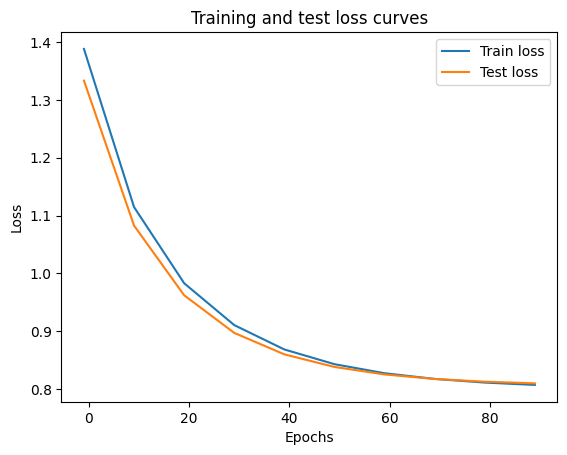

In [ ]:
# no optim

model_0 = SimpleModel()

# Loss Function
loss_fn = RMSLELoss()

# learning rate
learning_rate = 0.001

# Create an optimizer
# optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# data
y_train = train_label_tensor
x_train = train_data_tensor
y_test = test_label_tensor
x_test = test_data_tensor

# Set the number of epochs
epochs = 100

# loss values
train_loss_values = []
test_loss_values = []

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_train_pred = model_0(x_train)
  
    # 2. Calculate loss
    loss = loss_fn(y_train_pred, y_train)

    # print(y_train_pred.squeeze())
    # print(y_train.squeeze())
    # print(loss)

    # 3. Optimizer zero grad
    # optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    # optimizer.step()

    # Update parameters
    with torch.no_grad():
        for param in model_0.parameters():
            param -= learning_rate * param.grad
        model_0.zero_grad()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        y_test_pred = model_0(x_test)
        # 2. Caculate loss
        test_loss = loss_fn(y_test_pred, y_test)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 9:
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

epoch_list = []
for i in range(epochs // 10):
    epoch_list.append((i-1)*10+9)

plt.plot(epoch_list, train_loss_values, label="Train loss")
plt.plot(epoch_list, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


In [ ]:
optim_list = [
    "Adam",
    "SGD",
    "RMSprop"
]

Optimizer: Adam
Epoch: 9 | Loss: 0.81852 | Test loss: 0.85042
Epoch: 19 | Loss: 0.86191 | Test loss: 0.88220
Epoch: 29 | Loss: 0.80675 | Test loss: 0.81503
Epoch: 39 | Loss: 0.79751 | Test loss: 0.80408
Epoch: 49 | Loss: 0.79328 | Test loss: 0.79931
Epoch: 59 | Loss: 0.79116 | Test loss: 0.79646
Epoch: 69 | Loss: 0.78918 | Test loss: 0.79268
Epoch: 79 | Loss: 0.78768 | Test loss: 0.79079
Epoch: 89 | Loss: 0.78630 | Test loss: 0.78881
Epoch: 99 | Loss: 0.78469 | Test loss: 0.78696
Optimizer: SGD
Epoch: 9 | Loss: 1.47429 | Test loss: 1.37666
Epoch: 19 | Loss: 1.09148 | Test loss: 1.05471
Epoch: 29 | Loss: 0.95545 | Test loss: 0.93492
Epoch: 39 | Loss: 0.88827 | Test loss: 0.87634
Epoch: 49 | Loss: 0.85168 | Test loss: 0.84520
Epoch: 59 | Loss: 0.83080 | Test loss: 0.82802
Epoch: 69 | Loss: 0.81849 | Test loss: 0.81831
Epoch: 79 | Loss: 0.81105 | Test loss: 0.81274
Epoch: 89 | Loss: 0.80646 | Test loss: 0.80953
Epoch: 99 | Loss: 0.80358 | Test loss: 0.80769
Optimizer: RMSprop
Epoch: 9 | L

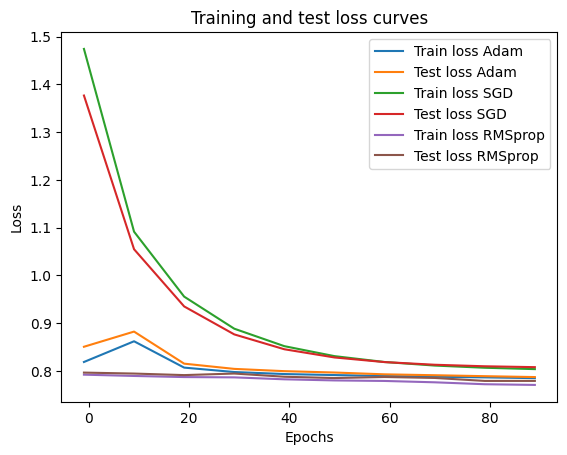

In [ ]:
for optim in optim_list:
    
    print("="*30)
    print("Optimizer:", optim)
    print("="*30)

    model_0 = SimpleModel()

    # Loss Function
    loss_fn = RMSLELoss()

    # Create an optimizer
    optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
    if optim.__eq__("Adam"):
        optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
    elif optim.__eq__("SGD"):
        optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)
    elif optim.__eq__("RMSprop"):
        optimizer = torch.optim.RMSprop(params=model_0.parameters(), lr=0.001)

    # data
    y_train = train_label_tensor
    x_train = train_data_tensor
    y_test = test_label_tensor
    x_test = test_data_tensor

    # Set the number of epochs
    epochs = 100

    # loss values
    train_loss_values = []
    test_loss_values = []

    # Build training and evaluation loop
    for epoch in range(epochs):
        ### Training
        model_0.train()

        # 1. Forward pass (model outputs raw logits)
        y_train_pred = model_0(x_train)
    
        # 2. Calculate loss
        loss = loss_fn(y_train_pred, y_train)

        # print(y_train_pred.squeeze())
        # print(y_train.squeeze())
        # print(loss)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model_0.eval()
        with torch.inference_mode():
            # 1. Forward pass
            y_test_pred = model_0(x_test)
            # 2. Caculate loss
            test_loss = loss_fn(y_test_pred, y_test)

        # Print out what's happening every 10 epochs
        if epoch % 10 == 9:
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

    epoch_list = []
    for i in range(epochs // 10):
        epoch_list.append((i-1)*10+9)

    plt.plot(epoch_list, train_loss_values, label="Train loss " + optim)
    plt.plot(epoch_list, test_loss_values, label="Test loss " + optim)
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()